# 🎬 Movie Recommender System (Collaborative Filtering with Surprise)

This project uses the MovieLens dataset to build a recommendation system using the SVD algorithm from the `surprise` library.

### 📌 Key Features:
- Data Cleaning & EDA
- Popular Movie Insights
- Collaborative Filtering (SVD)
- Personalized Movie Recommendations


## 📂 Step 1: Load the Data

Let’s start by loading the MovieLens dataset — we’ll use the movies and ratings files for now.


In [ ]:
import pandas as pd

# Load the CSV files
movies = pd.read_csv('../data/movies.csv')
ratings = pd.read_csv('../data/ratings.csv')


In [2]:
# Merge the ratings and movies datasets on 'movieId'
df = pd.merge(ratings, movies, on='movieId')

# Show the first few rows of the merged dataset
df.head()



,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


## 🔍 Step 2: Explore the Data

Before jumping into modeling, I wanted to get a feel for the data — how many users, how many ratings, and which movies were most popular.


In [5]:
# Check how many users and movies we have
print("📦 Total Ratings:", len(df))
print("👤 Unique Users:", df['userId'].nunique())
print("🎥 Unique Movies:", df['movieId'].nunique())

# Check for any missing values
print("\n🔍 Missing values in each column:")
print(df.isnull().sum())


📦 Total Ratings: 100836
👤 Unique Users: 610
🎥 Unique Movies: 9724

🔍 Missing values in each column:
userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64


## 📊 Top Rated & Most Watched Movies

Let’s look at which movies were most rated, and which had the highest average rating (with enough votes).


In [6]:
# Count how many ratings each movie has
movie_counts = df['title'].value_counts().head(10)

# Show top 10 most rated movies
print("🎥 Top 10 Most Rated Movies:")
print(movie_counts)


🎥 Top 10 Most Rated Movies:
title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64


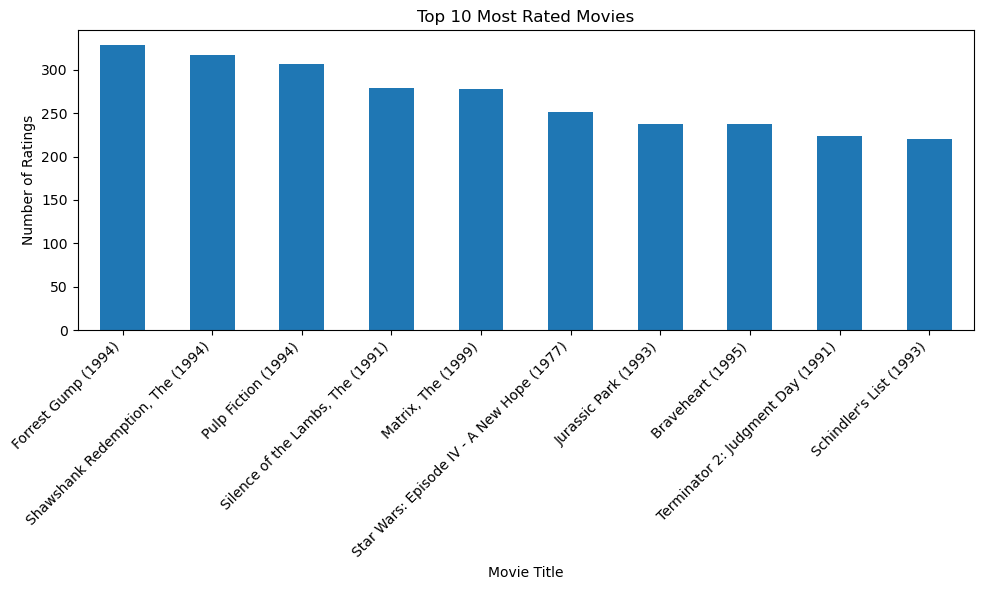

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
movie_counts.plot(kind='bar')
plt.title("Top 10 Most Rated Movies")
plt.ylabel("Number of Ratings")
plt.xlabel("Movie Title")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [8]:
# Calculate average rating and rating count per movie
rating_stats = df.groupby('title')['rating'].agg(['mean', 'count'])

# Filter to only movies with at least 100 ratings
popular_highly_rated = rating_stats[rating_stats['count'] >= 100].sort_values(by='mean', ascending=False).head(10)


print("🏆 Top 10 Highest Rated Movies (100+ ratings):")
display(popular_highly_rated)


🏆 Top 10 Highest Rated Movies (100+ ratings):


,mean,count
title,,
"Shawshank Redemption, The (1994)",4.429022,317
"Godfather, The (1972)",4.289062,192
Fight Club (1999),4.272936,218
"Godfather: Part II, The (1974)",4.259690,129
"Departed, The (2006)",4.252336,107
Goodfellas (1990),4.250000,126
Casablanca (1942),4.240000,100
"Dark Knight, The (2008)",4.238255,149
"Usual Suspects, The (1995)",4.237745,204


## 🧐 Mini Investigation: What Happened to Forrest Gump?

I noticed that *Forrest Gump* was the **most rated movie** in the dataset, but it didn’t appear in the list of top 10 highest-rated films.

That felt surprising — so I decided to dig into it.

Let’s check how well it was rated on average.
f.


In [9]:
forrest = rating_stats.loc['Forrest Gump (1994)']
print(f"Forrest Gump - Average Rating: {forrest['mean']:.2f}, Count: {int(forrest['count'])}")


Forrest Gump - Average Rating: 4.16, Count: 329


As it turns out, *Forrest Gump* has an average rating of **4.16** — which is really good,  
but just **slightly lower** than the 4.23+ ratings of the top 10.

So it’s not a bad movie — it just didn’t make the final cut under the filter of “100+ reviews and highest average rating.”

Still a classic though 🍿


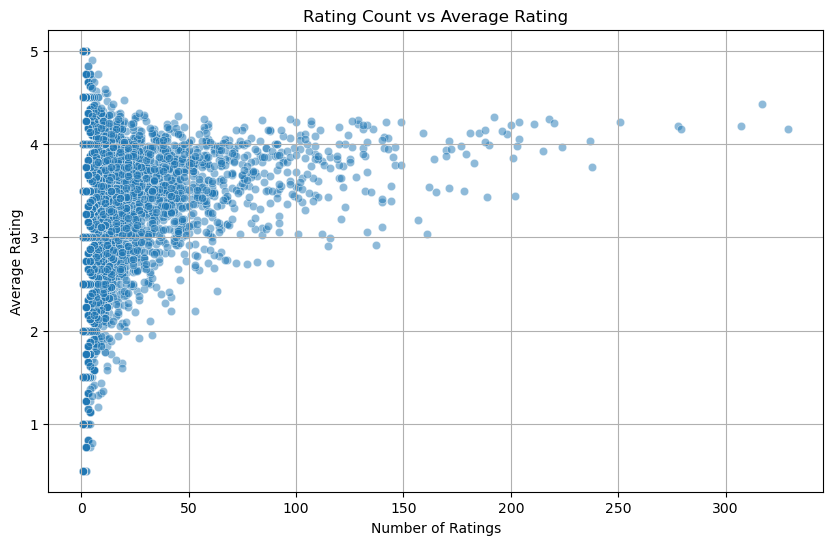

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(data=rating_stats, x='count', y='mean', alpha=0.5)
plt.title("Rating Count vs Average Rating")
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()


## 🧠 Step 3: Build the Recommender Model

Now comes the fun part — training a recommendation model using collaborative filtering. I used Surprise’s SVD algorithm to predict what users might like.


In [11]:
from surprise import Dataset, Reader

# Define how Surprise should read the data
reader = Reader(rating_scale=(0.5, 5.0))  # MovieLens ratings go from 0.5 to 5.0

# Load the data into Surprise's format
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)


In [12]:
from surprise import SVD
from surprise.model_selection import cross_validate

# Create an instance of the SVD algorithm
model = SVD()

# Evaluate model performance using cross-validation
results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8710  0.8708  0.8751  0.8715  0.8833  0.8743  0.0047  
MAE (testset)     0.6665  0.6690  0.6724  0.6725  0.6788  0.6718  0.0041  
Fit time          0.82    0.90    0.90    0.85    0.80    0.85    0.04    
Test time         0.08    0.08    0.07    0.08    0.16    0.10    0.03    


In [13]:
# Train the model on the whole dataset (so we can make predictions)
trainset = data.build_full_trainset()
model.fit(trainset)

# Predict a rating: userId=1 for movieId=1 (Toy Story)
prediction = model.predict(uid=1, iid=1)
print(f"🎯 Predicted rating for User 1 on Movie 1: {prediction.est:.2f}")


🎯 Predicted rating for User 1 on Movie 1: 4.56


## 🎯 Step 4: Predict Ratings & Recommend Movies

After training, I used the model to predict how a user might rate a movie they haven’t seen yet. Then, I built a simple function to recommend top movies based on those predictions.


In [14]:
def get_top_n_recommendations(user_id, model, df, n=5):
    # Get all movie IDs the user has already rated
    rated_movie_ids = df[df['userId'] == user_id]['movieId'].tolist()

    # Get a list of all movie IDs in the dataset
    all_movie_ids = df['movieId'].unique()

    # Filter out movies the user has already rated
    movies_to_predict = [mid for mid in all_movie_ids if mid not in rated_movie_ids]

    # Predict ratings for all unseen movies
    predictions = [model.predict(user_id, movie_id) for movie_id in movies_to_predict]

    # Sort predictions by estimated rating (descending)
    top_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    # Get the movie titles for the top predictions
    top_movie_ids = [pred.iid for pred in top_predictions]
    top_movies = df[df['movieId'].isin(top_movie_ids)][['movieId', 'title']].drop_duplicates()

    # Add predicted ratings to the result
    top_movies['Predicted Rating'] = [pred.est for pred in top_predictions]

    return top_movies.sort_values(by='Predicted Rating', ascending=False).reset_index(drop=True)


In [15]:
get_top_n_recommendations(user_id=1, model=model, df=df, n=5)


,movieId,title,Predicted Rating
0,318,"Shawshank Redemption, The (1994)",5.0
1,48516,"Departed, The (2006)",5.0
2,91529,"Dark Knight Rises, The (2012)",5.0
3,720,Wallace & Gromit: The Best of Aardman Animatio...,5.0
4,2288,"Thing, The (1982)",5.0


## ✅ Conclusion

This was a fun and practical project to build a basic movie recommendation system using collaborative filtering.

I got hands-on experience with:
- Data cleaning and exploration
- Working with the MovieLens dataset
- Building and evaluating an SVD-based recommender model
- Predicting personalized ratings
- Writing a simple function to recommend top movies

It was also cool to dig into surprises in the data — like why Forrest Gump didn’t show up in the top-rated list 👀

---

## 🚀 What's Next?

Here are a few ideas I might explore in the next version of this project:

- Use other algorithms like KNN or SVD++
- Build a content-based recommender using genres or tags
- Create a small app (Streamlit) where users can get recommendations live
- Add genre-based filters or rating thresholds

Thanks for reading! 🙌
